# DenseNet Model

this file will use folder "dataset_used" that generate from "BreakHisModel-1.ipynb"
and this will be used transfer learning / pre trained model RestNet

In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
# rm -rf ./logs/

In [2]:
# Checking their lengths
# train 
len_train_benign = len(os.listdir("../data_magnify/400x/Cancer_train/benign/"))
len_train_malignant = len(os.listdir("../data_magnify/400x/Cancer_train/malignant/"))
# test 
len_test_benign = len(os.listdir("../data_magnify/400x/Cancer_test/benign/"))
len_test_malignant = len(os.listdir("../data_magnify/400x/Cancer_test/malignant/"))
# val 
len_validation_benign = len(os.listdir("../data_magnify/400x/Cancer_validation/benign/"))
len_validation_malignant = len(os.listdir("../data_magnify/400x/Cancer_validation/malignant/"))

print("Training Data:")
print(" ")
print("Benign   :", len_train_benign)
print("Malignant:", len_train_malignant)
print(" ")
print("Validation Data")
print(" ")
print("Benign size    :",len_validation_benign)
print("Malignant size :",len_validation_malignant)
print(" ")
print("Testing Data:")
print(" ")
print("Benign size    :",len_test_benign)
print("Malignant size :",len_test_malignant)

Training Data:
 
Benign   : 994
Malignant: 994
 
Validation Data
 
Benign size    : 24
Malignant size : 54
 
Testing Data:
 
Benign size    : 89
Malignant size : 184


# Image Data Generator
- Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [3]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [4]:
# Setting up the images for image data generator
train_generator = datagen.flow_from_directory(
  "../data_magnify/400x/Cancer_train/",
  target_size=(128, 128),
  class_mode="categorical",
  batch_size = 32,
  )

val_generator = datagen.flow_from_directory(
  "../data_magnify/400x/Cancer_validation/", 
  target_size=(128, 128), 
  class_mode="categorical",
  batch_size=32, 
  )

  # Loading the test data using Image Data Generator
test_generator = datagen.flow_from_directory(
  "../data_magnify/400x/Cancer_test/", 
  target_size=(128,128), 
  class_mode="categorical", 
  batch_size=1, 
  shuffle=False
  )

Found 1988 images belonging to 2 classes.
Found 78 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


# DenseNet Layer config

In [5]:
#Defining the base model -> Fine Tune
DenseNet121_layer = DenseNet121(
  include_top=False,
  input_shape=(128, 128, 3)
)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(DenseNet121_layer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in DenseNet121_layer.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  427


In [ ]:
DenseNet121_layer.summary()

# LR optimizer
- tf.keras.optimizers.schedules.InverseTimeDecay

In [15]:
N_TRAIN = int(len_train_benign) * 2
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [16]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
step = np.linspace(0,2216)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

# HyperParameter Tuning
- epoch[0, 0,2, 0,4]

In [ ]:
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.2, 0.4]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    # RestNet Layer
    DenseNet121_layer,
    
    # Flattening the layers
    Flatten(),

    # Adding the dense layer
    Dropout(hparams[HP_DROPOUT]),
    Dense(256, activation='relu'),
    
    Dropout(hparams[HP_DROPOUT]),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax'),
  ])
  model.compile(
    loss='categorical_crossentropy', 
    optimizer = get_optimizer(), 
    metrics = ['accuracy']
  )

  model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15,
    callbacks=[early_stop],
    verbose = 1
  ) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_generator)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
start_time_HP = time.time()

session_num = 0
for dropout_rate in HP_DROPOUT.domain.values:
  hparams = {
    HP_DROPOUT: dropout_rate,
  }
  run_name = "run-%d" % session_num
  print('--- Starting trial: %s' % run_name)
  print({h.name: hparams[h] for h in hparams})
  run('logs/hparam_tuning/' + run_name, hparams)
  session_num += 1

In [ ]:
end_time_HP = time.time()

In [ ]:
Total_time_second= end_time_HP - start_time_HP
convert_minute = (Total_time_second) // 60
modulo_second = (Total_time_second) % 60
print("total time run HyperParameter Tune : {} Minutes, {} Seconds".format(convert_minute, modulo_second) )

In [ ]:
%tensorboard --logdir logs/hparam_tuning

# model CNN Pretrained model
- with DenseNet

In [6]:
cancer_model = Sequential([
  # RestNet Layer
  DenseNet121_layer,
  
  # Flattening the layers
  Flatten(),
  Dropout(0.2),

  # Adding the dense layer
  Dense(256, activation='relu'),
  Dropout(0.2),
  
  Dense(128, activation='relu'),
  Dense(2, activation='softmax'),
])

# cancer_model.layers[0].trainable = False
cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dropout (Dropout)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 2

In [ ]:
# Compiling the model
cancer_model.compile(
  loss='categorical_crossentropy', 
  optimizer = get_optimizer(), 
  metrics = ['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
# Model is fitted using train and validation generator for 200 epochs
import time

start_time = time.time()

history = cancer_model.fit(
  train_generator, 
  validation_data=val_generator, 
  epochs=200 ,
  callbacks=[early_stop],
  verbose = 1
  )

In [ ]:
end_time = time.time()
print("The time of execution of above program is :",(end_time-start_time) * 10**3, "ms")

In [ ]:
Total_time_second= end_time-start_time
convert_minute = (Total_time_second) // 60
modulo_second = (Total_time_second) % 60
print("total time run : {} Minutes, {} Seconds".format(convert_minute, modulo_second) )

In [ ]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
pred = cancer_model.evaluate(test_generator)

In [ ]:
# os.mkdir("../src/output/denseNet")

In [ ]:
cancer_model.save(filepath="../src/output/denseNet/denseNet_40x.h5")

# Load model and model evaluation

In [ ]:
cancer_model.load_weights(filepath="../src/output/denseNet/denseNet_40x.h5")

## test load model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

pred = cancer_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

print("==== Confusion Mtrix ====")
print(confusion_matrix(test_generator.classes, y_pred))

In [ ]:
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
print(classification_report(test_generator.classes, y_pred))

# Load model and model evaluation with model all magnify

In [16]:
cancer_model.load_weights(filepath="../src/output/denseNet/denseNet_HP.h5")

## test load model

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

pred = cancer_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

print("==== Confusion Mtrix ====")
print(confusion_matrix(test_generator.classes, y_pred))

273/273 [==============================] - 9s 32ms/step
==== Confusion Mtrix ====
[[ 89   0]
 [  7 177]]


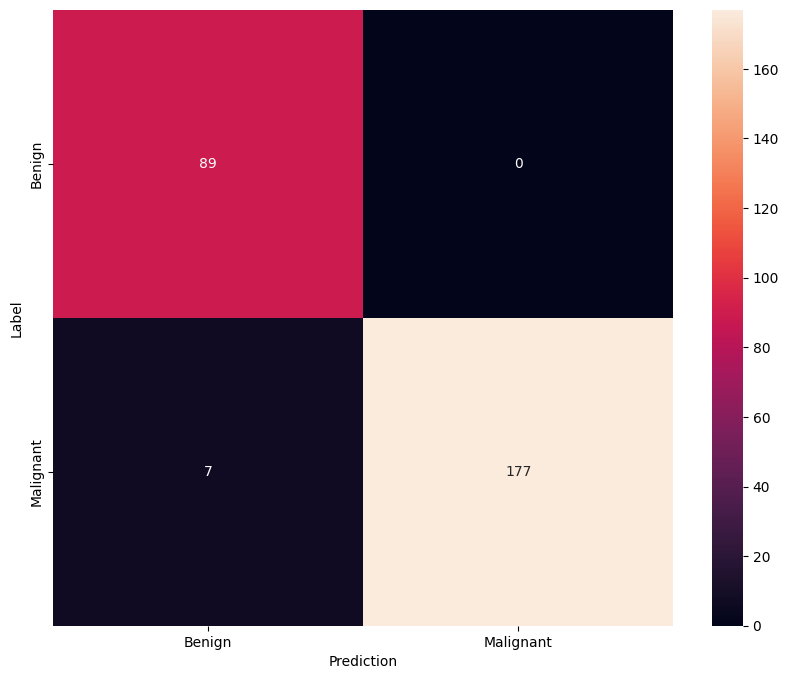

In [18]:
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [19]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        89
           1       1.00      0.96      0.98       184

    accuracy                           0.97       273
   macro avg       0.96      0.98      0.97       273
weighted avg       0.98      0.97      0.97       273

